In [ ]:
!pip3 install qiskit
!pip3 install pennylane
!pip3 install pennylane-qiskit
!pip3 install frechetdist
!pip3 install kora

import kora.install.rdkit # https://github.com/korakot/kora, lets us install rdkit on colab notebooks with eas

from rdkit import Chem

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

import pennylane as qml
import numpy as np
import random
import csv
import pandas as pd
import argparse
import os
import math
import datetime
import time
import matplotlib.pyplot as plt

from frechetdist import frdist
from qiskit import IBMQ

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.backends import cudnn


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

# QGAN

Dependency https://github.com/jundeli/quantum-gan. PennyLane and Pytorch implementation of QGAN-HG: Quantum generative models for small molecule drug discovery, based on MolGAN, @cite https://arxiv.org/abs/2101.03438

Generative Adversarial Networks, or GANs for short, are an approach to generative modeling using deep learning methods, such as convolutional neural networks.

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

GANs are a clever way of training a generative model by framing the problem as a supervised learning problem with two sub-models: the generator model that we train to generate new examples, and the discriminator model that tries to classify examples as either real (from the domain) or fake (generated). The two models are trained together in a zero-sum game, adversarial, until the discriminator model is fooled about half the time, meaning the generator model is generating plausible examples.


In [ ]:
!git clone https://github.com/jundeli/quantum-gan.git

Cloning into 'quantum-gan'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 266 (delta 51), reused 6 (delta 4), pack-reused 140
Receiving objects: 100% (266/266), 4.17 MiB | 5.21 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [ ]:
import os
os.chdir("quantum-gan/data/")

Now we need to download the dataset in question

In [23]:
%%bash
wget http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/gdb9.tar.gz 
tar xvzf gdb9.tar.gz
rm gdb9.tar.gz
wget https://github.com/gablg1/ORGAN/raw/master/organ/NP_score.pkl.gz
wget https://github.com/gablg1/ORGAN/raw/master/organ/SA_score.pkl.gz

--2022-01-23 00:33:07--  http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/gdb9.tar.gz
Resolving deepchem.io.s3-website-us-west-1.amazonaws.com (deepchem.io.s3-website-us-west-1.amazonaws.com)... 52.219.112.3
Connecting to deepchem.io.s3-website-us-west-1.amazonaws.com (deepchem.io.s3-website-us-west-1.amazonaws.com)|52.219.112.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44852087 (43M) [application/x-gzip]
Saving to: ‘gdb9.tar.gz’

     0K .......... .......... .......... .......... ..........  0%  305K 2m23s
    50K .......... .......... .......... .......... ..........  0% 3.09M 78s
   100K .......... .......... .......... .......... ..........  0%  708K 73s
   150K .......... .......... .......... .......... ..........  0% 18.8M 55s
   200K .......... .......... .......... .......... ..........  0%  586K 59s
   250K .......... .......... .......... .......... ..........  0% 69.8M 49s
   300K .......... .......... .......... .......... ....

see https://github.com/nicola-decao/MolGAN/blob/master/utils/sparse_molecular_dataset.py

In [24]:
!python sparse_molecular_dataset.py

  File "sparse_molecular_dataset.py", line 177
    features = np.array([[*[a.GetDegree() == i for i in range(5)],
                          ^
SyntaxError: invalid syntax


In [25]:
os.chdir("quantum-gan")

FileNotFoundError: [Errno 2] No such file or directory: 'quantum-gan'

Now to set up IBM Quantum. In this case I am running it on a simulator, but you can run it on real hardware if need be. 

In [ ]:
from data_loader import get_loader
from utils import *
from models import Generator, Discriminator
from data.sparse_molecular_dataset import SparseMolecularDataset

def str2bool(v):
    return v.lower() in ('true')

qubits = 8 # set to 5 for real hardware 
provider = IBMQ.enable_account('a63b6a1cf53003aefe2ae45e4c33c98cf203d4e30fe96cdb091d38a8f81145e22c207f3bacd65d90d9dd3e85022f0cace70d2aa471b555124450d14296f897b1')
dev = qml.device('qiskit.ibmq', wires=qubits, backend='ibmq_qasm_simulator', provider=provider) # set backend to ibmq_manila for actual hardware

@qml.qnode(dev, interface='torch')
def gen_circuit(w):
    # random noise as generator input
    #z1 and z2 are random noise parameters.
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    #number of layers in the circuit
    layers = 1    
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
        
    for l in range(layers):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

# Set up the Parser

In [ ]:
parser = argparse.ArgumentParser()

Quantum circuit configuration

In [ ]:
parser.add_argument('--quantum', type=bool, default=True, help='choose to use quantum gan with hybrid generator')
parser.add_argument('--patches', type=int, default=1, help='number of quantum circuit patches')
parser.add_argument('--layer', type=int, default=1, help='number of repeated variational quantum layer')
parser.add_argument('--qubits', type=int, default=8, help='number of qubits and dimension of domain labels')

_StoreAction(option_strings=['--qubits'], dest='qubits', nargs=None, const=None, default=8, type=<class 'int'>, choices=None, help='number of qubits and dimension of domain labels', metavar=None)

Model configuration

In [ ]:
parser.add_argument('--z_dim', type=int, default=8, help='dimension of domain labels')
parser.add_argument('--g_conv_dim', default=[128], help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=[[128, 64], 128, [128, 64]], help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')
parser.add_argument('--post_method', type=str, default='softmax', choices=['softmax', 'soft_gumbel', 'hard_gumbel'])

_StoreAction(option_strings=['--post_method'], dest='post_method', nargs=None, const=None, default='softmax', type=<class 'str'>, choices=['softmax', 'soft_gumbel', 'hard_gumbel'], help=None, metavar=None)

Training configuration

In [ ]:
parser.add_argument('--batch_size', type=int, default=16, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=5000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=2500, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--dropout', type=float, default=0., help='dropout rate')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')

_StoreAction(option_strings=['--resume_iters'], dest='resume_iters', nargs=None, const=None, default=None, type=<class 'int'>, choices=None, help='resume training from this step', metavar=None)

Test configuration

In [ ]:
parser.add_argument('--test_iters', type=int, default=5000, help='test model from this step')

_StoreAction(option_strings=['--test_iters'], dest='test_iters', nargs=None, const=None, default=5000, type=<class 'int'>, choices=None, help='test model from this step', metavar=None)

Misc Config

In [ ]:
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='train', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=False)

_StoreAction(option_strings=['--use_tensorboard'], dest='use_tensorboard', nargs=None, const=None, default=False, type=<function str2bool at 0x7f602ede8c20>, choices=None, help=None, metavar=None)

Directories

In [ ]:
parser.add_argument('--mol_data_dir', type=str, default='data/gdb9_9nodes.sparsedataset')
parser.add_argument('--log_dir', type=str, default='qgan-hg/logs')
parser.add_argument('--model_save_dir', type=str, default='qgan-hg/models')
parser.add_argument('--sample_dir', type=str, default='qgan-hg/samples')
parser.add_argument('--result_dir', type=str, default='qgan-hg/results')

_StoreAction(option_strings=['--result_dir'], dest='result_dir', nargs=None, const=None, default='qgan-hg/results', type=<class 'str'>, choices=None, help=None, metavar=None)

Step Size

In [ ]:
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=1000)
parser.add_argument('--lr_update_step', type=int, default=500)

NameError: ignored

Double check the config

In [ ]:
config = parser.parse_known_args()[0]
from solver import Solver
self = Solver(config)

Generator(
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.0, inplace=True)
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropoout): Dropout(p=0.0, inplace=False)
)
G
The number of parameters: 59202
Discriminator(
  (gcn_layer): GraphConvolution(
    (linear1): Linear(in_features=5, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (agg_layer): GraphAggregation(
    (sigmoid_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Sigmoid()
    )
    (tanh_linear): Sequential(
      (0): Linear(in_features=69, out_features=128, bias=True)
      (1): Tanh()
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=128, out_feature

# Inference of generated molecules

In [ ]:
start_iters = 0
self.resume_iters = 2580

if self.resume_iters:
    start_iters = self.resume_iters
    self.restore_model(self.resume_iters)
    gen_weights = torch.tensor([-0.11443097,-0.23893048,-0.26079974,0.52572775,0.04154618,0.7797117,\
                                -0.22719051,0.04173521,-0.7405998,0.040963333,0.13625668,0.5491951,0.41576374,-0.059020802,0.7136884], requires_grad=True)
ibm_sample_list = []
for i in range(self.batch_size):
    # Running time depends on the queue of IBM machine
    print("IBM Q running job {}/{}".format(i+1, self.batch_size), end="\r")
    ibm_sample_list.append(gen_circuit(gen_weights))


Loading the trained models from step 2580...


Start inference

In [ ]:
print('Start inference...')
start_time = time.time()
#a is the adjacency matrix and x are the nodes
mols, _, _, a, x, _, _, _, _ = self.data.next_train_batch(self.batch_size)

Start inference...


# Preprocess input data

Convert label indices to one-hot vectors

In [ ]:
a = torch.from_numpy(a).to(self.device).long()            # Adjacency.
x = torch.from_numpy(x).to(self.device).long()            # Nodes.
a_tensor = self.label2onehot(a, self.b_dim)
x_tensor = self.label2onehot(x, self.m_dim)
z = torch.stack(tuple(ibm_sample_list)).to(self.device).float()

Compute loss with fake images

In [ ]:
edges_logits, nodes_logits = self.G(z)

Postprocess with Gumbel softmax

In [ ]:
(edges_hat, nodes_hat) = self.postprocess((edges_logits, nodes_logits), self.post_method)
logits_fake, features_fake = self.D(edges_hat, None, nodes_hat)
g_loss_fake = - torch.mean(logits_fake)

Compute the loss with real images

In [ ]:
# Real Reward
rewardR = torch.from_numpy(self.reward(mols)).to(self.device)

# Fake Reward
(edges_hard, nodes_hard) = self.postprocess((edges_logits, nodes_logits), 'hard_gumbel')
edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
mols = [self.data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True)
        for e_, n_ in zip(edges_hard, nodes_hard)]
rewardF = torch.from_numpy(self.reward(mols)).to(self.device)

# Value loss
value_logit_real,_ = self.V(a_tensor, None, x_tensor, torch.sigmoid)
value_logit_fake,_ = self.V(edges_hat, None, nodes_hat, torch.sigmoid)
g_loss_value = torch.mean((value_logit_real - rewardR) ** 2 + (
                           value_logit_fake - rewardF) ** 2)

R=[list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_only = frdist(R, F)

R=[list(x[i]) + list(a[i].reshape(-1))  for i in range(self.batch_size)]
F=[list(nodes_hard[i]) + list(edges_hard[i].reshape(-1))  for i in range(self.batch_size)]
fd_bond_atom = frdist(R, F)

loss = {}
loss['G/loss_fake'] = g_loss_fake.item()
loss['G/loss_value'] = g_loss_value.item()
loss['FD/fd_bond_only'] = fd_bond_only
loss['FD/fd_bond_atom'] = fd_bond_atom

# Print out training information

In [ ]:
et = time.time() - start_time
et = str(datetime.timedelta(seconds=et))[:-7]

In [ ]:
log = "Elapsed [{}], Iteration [{}/{}]".format(et, start_iters, self.num_iters)
m0, m1 = all_scores(mols, self.data, norm=True)     # 'mols' is output of Fake Reward
m0 = {k: np.array(v)[np.nonzero(v)].mean() for k, v in m0.items()}
m0.update(m1)
loss.update(m0)
for tag, value in loss.items():
    log += ", {}: {:.4f}".format(tag, value)
print(log)

Elapsed [0:00:00], Iteration [2580/5000], G/loss_fake: -0.8730, G/loss_value: 0.0350, FD/fd_bond_only: 11.0905, FD/fd_bond_atom: 11.7473, NP score: 0.7503, QED score: 0.5270, logP score: 0.5009, SA score: 0.1398, diversity score: 1.0000, drugcandidate score: 0.4001, valid score: 75.0000, unique score: 100.0000, novel score: 100.0000


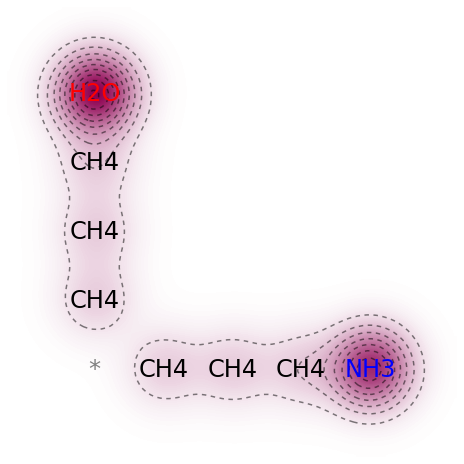

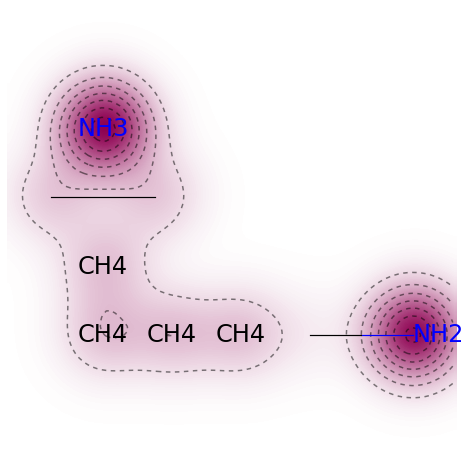

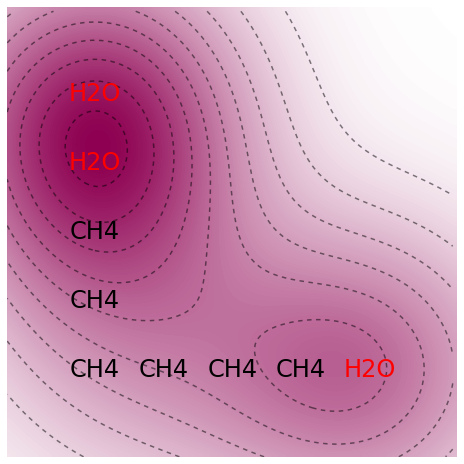

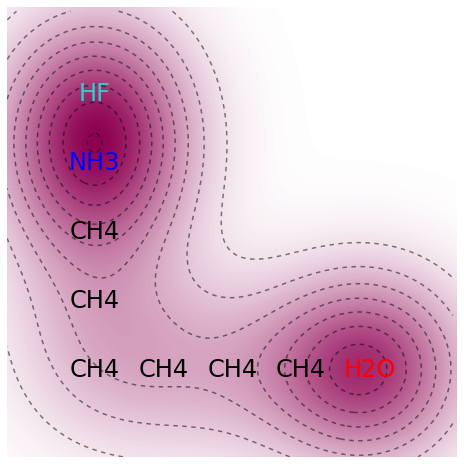

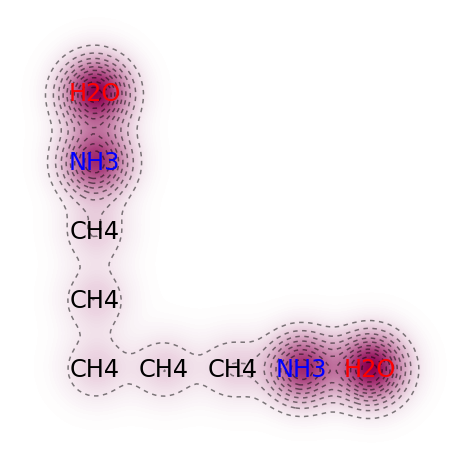

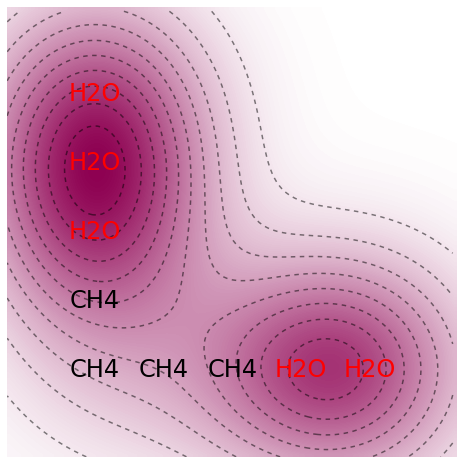

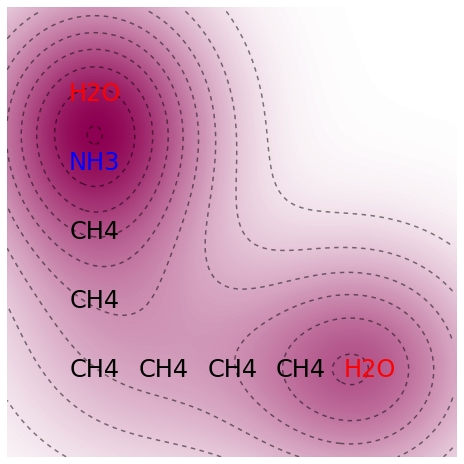

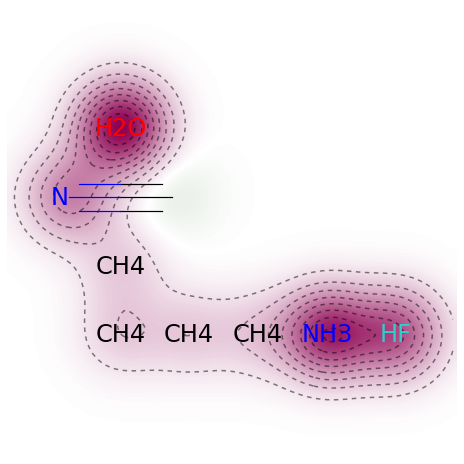

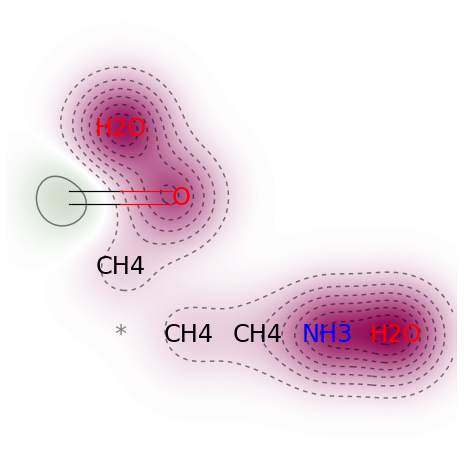

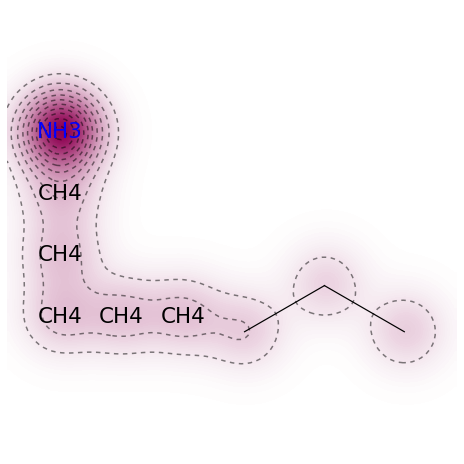

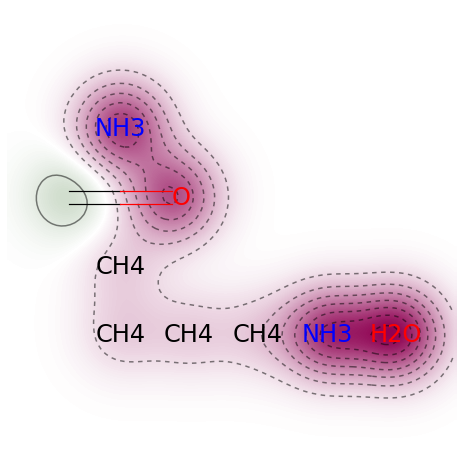

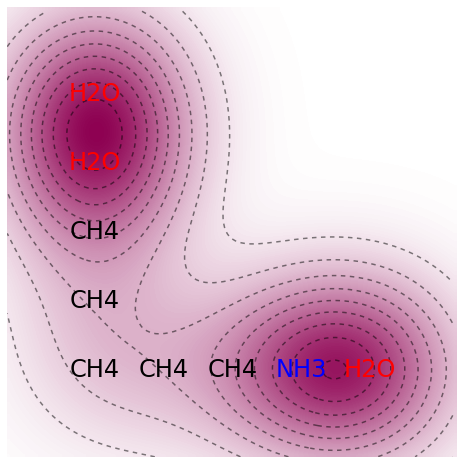

In [ ]:
valid_mols = [i for i in mols if i != None]

from rdkit.Chem.Draw import SimilarityMaps
import matplotlib

for mol in valid_mols:
    AllChem.ComputeGasteigerCharges(mol)
    contribs = [mol.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(mol.GetNumAtoms())]
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap=None,  contourLines=10)